#Modelo LSTM Multivariado

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import date
from tqdm import tqdm_notebook 
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# Constantes
CV_SIZE = 0.2            # Proporção do dataset utilizado para validação
TEST_SIZE = 0.2          # Proporção do dataset utilizado para teste
    
# Valores iniciais antes da otimização
N = 9                    # Tamanho da janela utilizada no treinamento (window size)
lstm_units=140           # Número de neurônios      
dropout_prob=0.2         # Taxa de eliminação     
optimizer='adam'         # Otimizador      
epochs=160               # Número de épocas
batch_size=16            # Tamanho do lote, número de exemplos de treinamento usados em uma iteração 

## Preparação dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Inserir o local da pasta onde estão os arquivos de entrada
workdir_path = '/content/drive/My Drive/' + '/Monografia/Análise do preço de comodities agrícolas/dados'
os.chdir(workdir_path)

Leitura do preço do CRB

In [ ]:
xls_file = pd.ExcelFile("./TR_CC CRB.xlsx") # Carregar excel
crb = xls_file.parse("TR_CC CRB") # Ler a folha Data 1
crb.columns = crb.iloc[1] # definir nome das colunas
crb.columns = ["date","crb_usd"]
crb["date"] = crb["date"].astype('datetime64[ns]')
crb['crb_usd'] = pd.to_numeric(crb['crb_usd'], errors='coerce').dropna(0)
print(crb)

           date  crb_usd
0    2021-07-16   212.58
1    2021-07-15   212.25
2    2021-07-14   213.38
3    2021-07-13   214.12
4    2021-07-12   212.71
...         ...      ...
4923 2002-01-08   153.80
4924 2002-01-07   154.21
4925 2002-01-04   153.05
4926 2002-01-03   149.04
4927 2002-01-02   150.90

[4928 rows x 2 columns]


Leitura dos preços das commodities

In [ ]:
# Leitura do arquivo csv
ccm = pd.read_csv("./CCM.csv", sep=';')
ccm.columns = ["date","ccm_brl", "ccm_usd"]
ccm["date"] = ccm["date"].astype('datetime64[ns]')
ccm['ccm_brl'] = pd.to_numeric(ccm['ccm_brl'], errors='coerce').dropna(0)
ccm['ccm_usd'] = pd.to_numeric(ccm['ccm_usd'], errors='coerce').dropna(0)
print(ccm)
sjc = pd.read_csv("./SJC.csv", sep=';')
sjc.columns = ["date","sjc_brl", "sjc_usd"]
sjc["date"] = sjc["date"].astype('datetime64[ns]')
sjc['sjc_brl'] = pd.to_numeric(sjc['sjc_brl'], errors='coerce').dropna(0)
sjc['sjc_usd'] = pd.to_numeric(sjc['sjc_usd'], errors='coerce').dropna(0)
print(sjc)
bgi = pd.read_csv("./BGI.csv", sep=';')
bgi.columns = ["date","bgi_brl", "bgi_usd"]
bgi["date"] = bgi["date"].astype('datetime64[ns]')
bgi['bgi_brl'] = pd.to_numeric(bgi['bgi_brl'], errors='coerce').dropna(0)
bgi['bgi_usd'] = pd.to_numeric(bgi['bgi_usd'], errors='coerce').dropna(0)
print(bgi)

           date  ccm_brl  ccm_usd
0    2004-08-02    18.24     5.98
1    2004-08-03    18.04     5.91
2    2004-08-04    18.02     5.90
3    2004-08-05    18.06     5.89
4    2004-08-06    18.13     5.98
...         ...      ...      ...
4216 2021-07-12    96.24    18.62
4217 2021-07-13    96.43    18.65
4218 2021-07-14    97.19    19.16
4219 2021-07-15    98.01    19.12
4220 2021-07-16    97.34    19.01

[4221 rows x 3 columns]
           date  sjc_brl  sjc_usd
0    2006-03-13    27.66    12.96
1    2006-03-14    27.45    12.91
2    2006-03-15    27.58    13.00
3    2006-03-16    26.97    12.78
4    2006-03-17    26.96    12.68
...         ...      ...      ...
3820 2021-07-12   165.83    32.08
3821 2021-07-13   167.62    32.42
3822 2021-07-14   168.72    33.27
3823 2021-07-15   168.90    32.96
3824 2021-07-16   170.39    33.28

[3825 rows x 3 columns]
           date  bgi_brl  bgi_usd
0    1997-07-23    26.67    24.65
1    1997-07-24    26.67    24.65
2    1997-07-25    26.71    24.6

Juntando as séries em um dataframe para criar um único índice pela coluna data

In [ ]:
commodity_df = ccm.merge(sjc, on=['date'], how='inner')
commodity_df = commodity_df.merge(bgi, on=['date'], how='inner')
commodity_df = commodity_df.merge(crb, on=['date'], how='inner')
commodity_df = commodity_df.set_index('date')
commodity_df

,ccm_brl,ccm_usd,sjc_brl,sjc_usd,bgi_brl,bgi_usd,crb_usd
date,,,,,,,
2006-03-13,15.21,7.13,27.66,12.96,50.13,23.49,322.99
2006-03-14,15.08,7.09,27.45,12.91,49.92,23.48,326.97
2006-03-15,14.62,6.89,27.58,13.00,49.79,23.47,325.63
2006-03-16,14.19,6.73,26.97,12.78,49.60,23.51,327.55
2006-03-17,14.30,6.73,26.96,12.68,49.56,23.31,325.83
...,...,...,...,...,...,...,...
2021-07-12,96.24,18.62,165.83,32.08,319.15,61.73,212.71
2021-07-13,96.43,18.65,167.62,32.42,318.00,61.50,214.12
2021-07-14,97.19,19.16,168.72,33.27,320.70,63.23,213.38


Período selecionado para o estudo após mesclagem das series de dados [2006-2021]

In [ ]:
min_date, max_date = min(commodity_df.index), max(commodity_df.index)
print(f"Peródo de estudo: {pd.Timestamp(min_date).year} à {pd.Timestamp(max_date).year}")

Peródo de estudo: 2006 à 2021


Concatenando as features das commodities pela coluna da cotação do milho

In [ ]:
features_data = pd.DataFrame()
scaler = MinMaxScaler()

output = commodity_df.drop(columns=['ccm_brl', 'sjc_brl', 'bgi_brl', 'bgi_usd', 'crb_usd'])
output.columns = ["ccm_usd", "commodity_usd"]
output["commodity_usd_scaled"] = scaler.fit_transform(output["commodity_usd"].to_frame())
output["name"] = 'SJC'
output["year"] = commodity_df.index.year
# Anexar dados ao dataframe total
features_data=features_data.append(output)

output = commodity_df.drop(columns=['ccm_brl', 'sjc_brl', 'sjc_usd', 'bgi_brl', 'crb_usd'])
output.columns = ["ccm_usd", "commodity_usd"]
output["commodity_usd_scaled"] = scaler.fit_transform(output["commodity_usd"].to_frame())
output["name"] = 'BGI'
output["year"] = commodity_df.index.year
# Anexar dados ao dataframe total
features_data=features_data.append(output)

output = commodity_df.drop(columns=['ccm_brl', 'sjc_brl', 'sjc_usd', 'bgi_brl', 'bgi_usd'])
output.columns = ["ccm_usd", "commodity_usd"]
output["commodity_usd_scaled"] = scaler.fit_transform(output["commodity_usd"].to_frame())
output["name"] = 'CRB'
output["year"] = commodity_df.index.year
# Anexar dados ao dataframe total
features_data=features_data.append(output)

features_data

,ccm_usd,commodity_usd,commodity_usd_scaled,name,year
date,,,,,
2006-03-13,7.13,12.96,0.017011,SJC,2006
2006-03-14,7.09,12.91,0.015492,SJC,2006
2006-03-15,6.89,13.00,0.018226,SJC,2006
2006-03-16,6.73,12.78,0.011543,SJC,2006
2006-03-17,6.73,12.68,0.008505,SJC,2006
...,...,...,...,...,...
2021-07-12,18.62,212.71,0.286469,CRB,2021
2021-07-13,18.65,214.12,0.290326,CRB,2021
2021-07-14,19.16,213.38,0.288302,CRB,2021


## Análise exploratória dos dados

Gáficos dos preços das commodities e do CRB

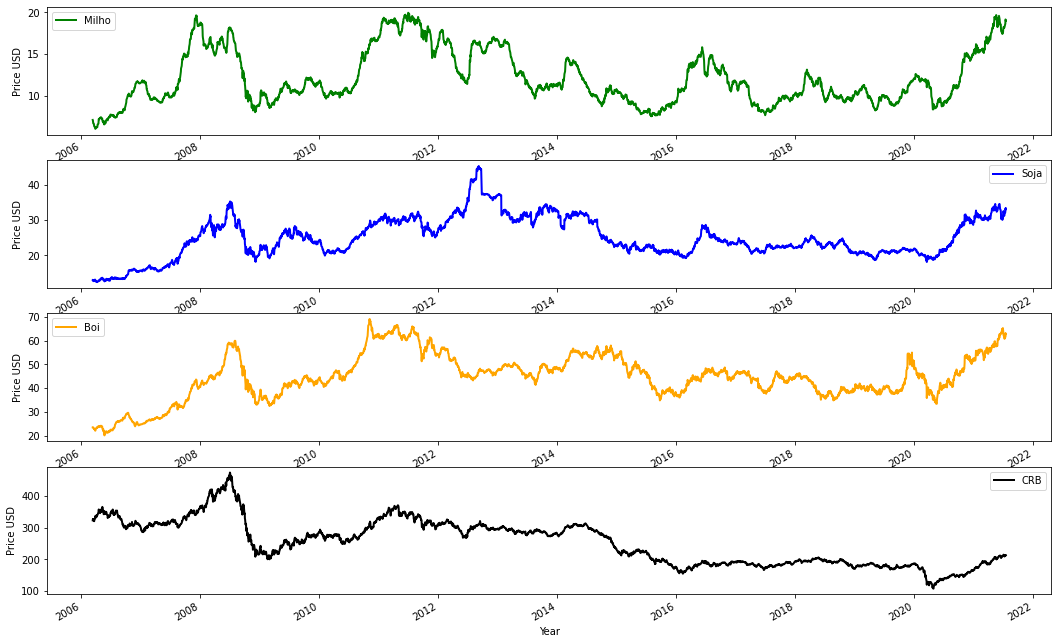

In [ ]:
fig = plt.figure(figsize=(18,12))

# Add a subplot
ax1 = fig.add_subplot(411, ylabel='Price USD')
commodity_df.ccm_usd.plot(ax=ax1, color='green', lw=2, label='Milho')
ax1.legend()

ax2 = fig.add_subplot(412, ylabel='Price USD')
commodity_df.sjc_usd.plot(ax=ax2, color='blue', lw=2, label='Soja')
ax2.legend()

ax3 = fig.add_subplot(413, ylabel='Price USD')
commodity_df.bgi_usd.plot(ax=ax3, color='orange', lw=2, label='Boi')
ax3.legend()

ax4 = fig.add_subplot(414, ylabel='Price USD')
commodity_df.crb_usd.plot(ax=ax4, color='black', lw=2, label='CRB')
ax4.legend()

plt.xlabel('Year')
plt.show()

Violin plot do preço das commodities

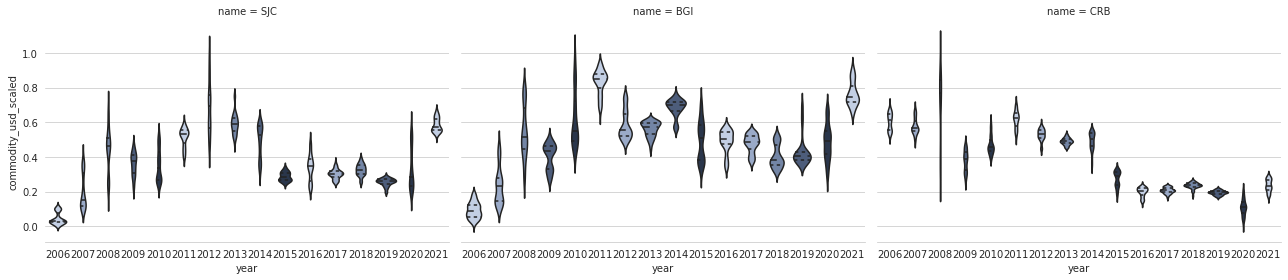

In [ ]:
sns.set_style("whitegrid")
palette=sns.cubehelix_palette(5, start=2.8, rot=0, dark=0.2, light=0.8, reverse=False)

sns.factorplot(x="year", y="commodity_usd_scaled", col='name', col_wrap=3,kind="violin",
               split=True, data=features_data, inner="quart", palette=palette, trim=True,size=4,aspect=1.5)
sns.despine(left=True)

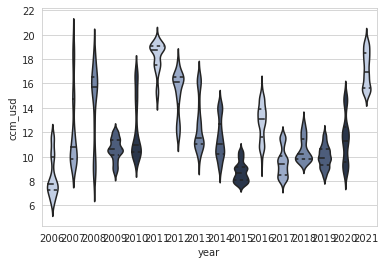

In [ ]:
#plt.figure(figsize=(12,8))
sns.violinplot(x="year", y="ccm_usd", data=features_data,
               inner="quart", palette=palette, trim=True)

Gráfico do preço do milho em relação às demais commodities, classificado por ano

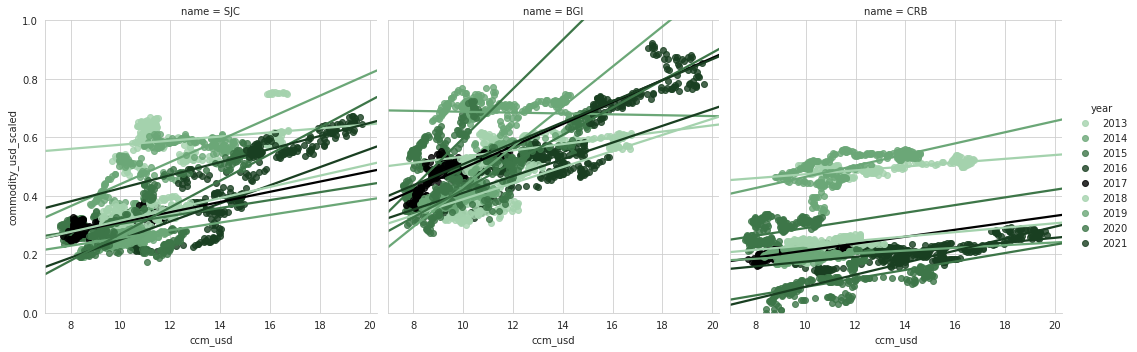

In [ ]:
features_data13 = features_data[(features_data['year']>2012)]

palette=sns.cubehelix_palette(5, start=2, rot=0, dark=0, light=.75, reverse=False)
sns.lmplot(x="ccm_usd", y="commodity_usd_scaled",hue="year", col="name",ci=None, 
           col_wrap=3, data=features_data13, order=1,palette=palette,size=5, truncate=False).set(ylim=(0, 1))

Matriz de correlação entre as séries. Para encontrar a correlação, foi utilizada a variação percentual em vez de usar diretamente o preços, pois os valores estão em escalas diferentes.

In [ ]:
commodity_df_pct_return = commodity_df.apply(lambda x: x.pct_change()[1:]).drop(columns=['ccm_brl', 'sjc_brl', 'bgi_brl'])
commodity_df_pct_return.describe()

,ccm_usd,sjc_usd,bgi_usd,crb_usd
count,3723.000000,3723.000000,3723.000000,3723.000000
mean,0.000359,0.000361,0.000350,-0.000045
std,0.013808,0.014658,0.013112,0.011576
min,-0.073975,-0.144130,-0.100828,-0.076368
25%,-0.007656,-0.007217,-0.006693,-0.005893
50%,0.000000,0.000719,0.000403,0.000383
75%,0.007965,0.008203,0.007557,0.006050
max,0.098636,0.095238,0.120554,0.076980


In [ ]:
# Find the correction matrix 
commodity_corr_df = commodity_df_pct_return.corr()
commodity_corr_df

,ccm_usd,sjc_usd,bgi_usd,crb_usd
ccm_usd,1.000000,0.496760,0.605875,0.332184
sjc_usd,0.496760,1.000000,0.486504,0.410193
bgi_usd,0.605875,0.486504,1.000000,0.335258
crb_usd,0.332184,0.410193,0.335258,1.000000


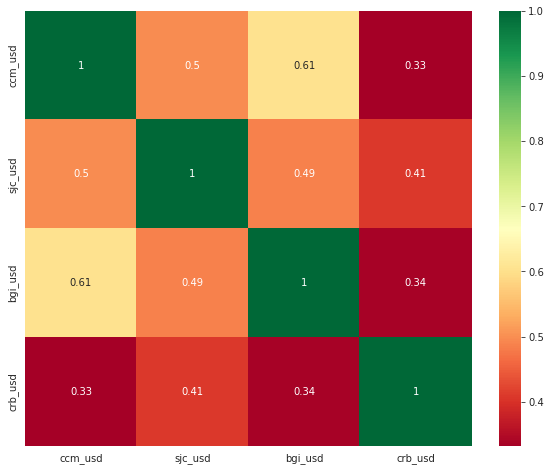

In [ ]:
# Gráfico do mapa de calor
plt.figure(figsize=(10,8))
sns.heatmap(commodity_corr_df, cmap='RdYlGn', annot=True)
plt.show()

## Construção e treinamento da rede LSTM

#### Funções comuns para calculo de métricas:

In [ ]:
#Função usada para calcular o MAPE
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Função usada para divide os dados em janelas (features) de acordo com o tamanho do parâmetro N 
def get_x(data, N, offset):
    #Split data into x (features)
    x = []
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
    x = np.array(x)
    return x

#Função usada para treinar, prever e avaliar o modelo
#Retorna mse, rmse, mape e est (valores previstos)
def train_pred_eval_model(x_train_scaled,
                          y_train_scaled,
                          x_cv_scaled,
                          y_cv,
                          scaler,
                          lstm_units,
                          dropout_prob=0.2,
                          optimizer='adam',
                          epochs=100,
                          batch_size=32):

    # Criação da rede LSTM
    model = Sequential()
    # Adiciona a primeira camada LSTM e Dropout
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
    model.add(Dropout(dropout_prob))
    # Adiciona a segunda camada LSTM e Dropout
    lstm_units_80_pct = round(lstm_units * 0.8) # definir 80% de neurônios para segunda camada
    model.add(LSTM(units=lstm_units_80_pct))
    model.add(Dropout(dropout_prob))
    # Adiciona a camada de saída
    model.add(Dense(1))
    # Compila a rede
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    # Treina a rede
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Efetua a previsão
    est_scaled = model.predict(x_cv_scaled)
    # Retorna à escala normal para cálculo das métricas
    est = scaler.inverse_transform(est_scaled.reshape(-1,1)).reshape(-1)
    mse = mean_squared_error(y_cv,est)
    rmse = math.sqrt(mse)
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est

#### Dividindo os dados em conjuntos de treino, validação e teste

In [ ]:
commodity_df_subset = commodity_df[(commodity_df.index.year >2008)].drop(columns=['ccm_brl', 'sjc_brl', 'bgi_brl'])

In [ ]:
num_cv = int(CV_SIZE * len(commodity_df_subset))
num_test = int(TEST_SIZE * len(commodity_df_subset))
num_train = len(commodity_df_subset) - num_test - num_cv
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))
print("num_train = " + str(num_train))

num_cv = 608
num_test = 608
num_train = 1828


In [ ]:
# Split into train, cv, and test
train = commodity_df_subset[:num_train]
cv = commodity_df_subset[num_train:num_train+num_cv]
train_cv = commodity_df_subset[:num_train+num_cv]
test = commodity_df_subset[num_train+num_cv:]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (1828, 4)
cv.shape = (608, 4)
train_cv.shape = (2436, 4)
test.shape = (608, 4)


In [ ]:
print("train = " + str(train))
print("cv = " + str(cv))
print("train_cv = " + str(train_cv))
print("test = " + str(test))

train =             ccm_usd  sjc_usd  bgi_usd  crb_usd
date                                          
2009-01-02     9.12    21.28    36.72   233.92
2009-01-05     9.53    22.03    38.08   237.33
2009-01-06    10.47    22.98    39.40   242.78
2009-01-07    10.47    22.39    38.01   231.49
2009-01-08    10.49    21.74    36.88   228.75
...             ...      ...      ...      ...
2016-07-06    12.33    26.97    46.76   189.96
2016-07-07    12.46    26.51    46.43   185.70
2016-07-08    12.67    26.66    47.47   187.17
2016-07-11    12.46    26.93    47.31   186.71
2016-07-12    12.69    27.08    47.55   190.23

[1828 rows x 4 columns]
cv =             ccm_usd  sjc_usd  bgi_usd  crb_usd
date                                          
2016-07-13    12.96    27.82    47.74   188.59
2016-07-14    13.29    27.84    48.11   190.10
2016-07-15    13.49    27.42    48.06   188.86
2016-07-18    13.84    26.99    48.01   188.19
2016-07-19    14.10    26.52    47.71   186.10
...             ...   

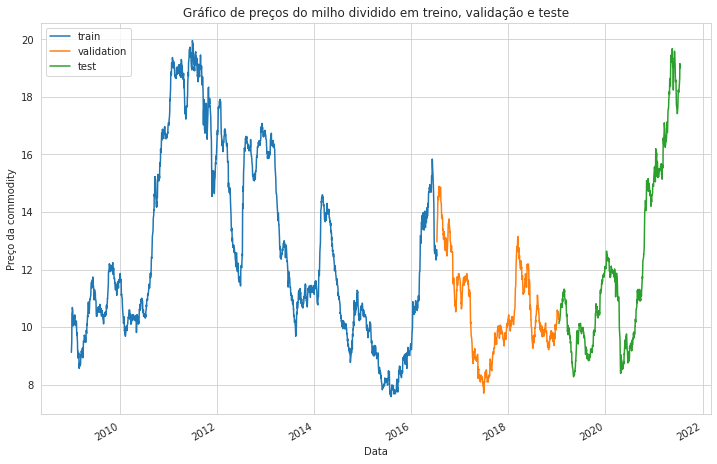

In [ ]:
# Gráfico dos conjuntos de treino, validação e teste, concatenados e destacados por cores.
plt.figure(figsize=(12,8))
ax = train['ccm_usd'].plot(label='train')
ax = cv['ccm_usd'].plot(ax=ax, label='validation')
test['ccm_usd'].plot(ax=ax, label='test')

plt.title('Gráfico de preços do milho dividido em treino, validação e teste')
plt.xlabel('Data')
plt.ylabel('Preço da commodity')
plt.legend()
plt.show()

#### Normalização dos dados de Treino e validação

In [ ]:
# Normalizamos apenas o dataset de treino e as features do dataset de validação, para evitar perda de informação

scaler_features = MinMaxScaler()
scaler_y_train = MinMaxScaler()
scaler_y_cv = MinMaxScaler()

train_scaled = scaler_features.fit_transform(train.iloc[:, 0:4].values)
print("train_scaled.shape = " + str(train_scaled.shape)) 

# Split into x and y
x_train_scaled = get_x(train_scaled, N, N)
y_train_scaled = scaler_y_train.fit_transform(train.iloc[N:, 0:1].values) #só coluna da série alvo
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) 
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) 

train_scaled.shape = (1828, 4)
x_train_scaled.shape = (1819, 9, 4)
y_train_scaled.shape = (1819, 1)


In [ ]:
# Scale the cv dataset
cv_scaled = scaler_features.fit_transform(cv.iloc[:, 0:4].values)
print("cv_scaled.shape = " + str(cv_scaled.shape)) 

# Split into x and y
x_cv_scaled = get_x(cv_scaled, N, N)
y_cv = cv.iloc[N:, 0:1].values #só coluna da série alvo

y_cv_scaled = scaler_y_cv.fit_transform(y_cv)

print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))

cv_scaled.shape = (608, 4)
x_cv_scaled.shape = (599, 9, 4)
y_cv.shape = (599, 1)


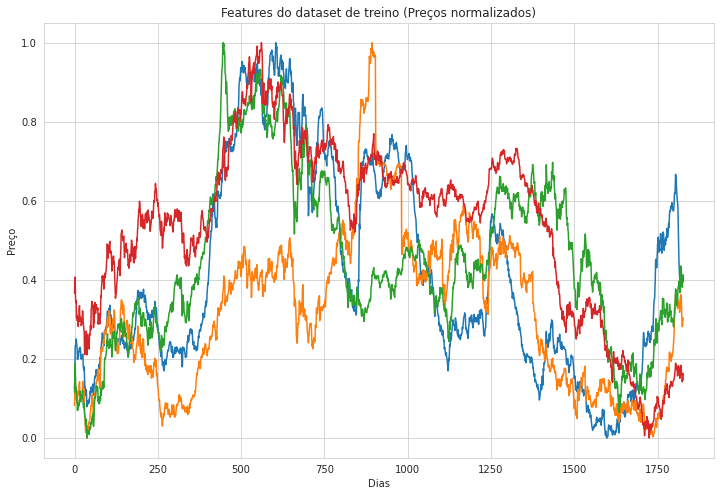

In [ ]:
# Mostra as features do dataset de treino
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(train_scaled)
plt.xlabel("Dias")
plt.ylabel("Preço")
plt.title("Features do dataset de treino (Preços normalizados)")
plt.show()

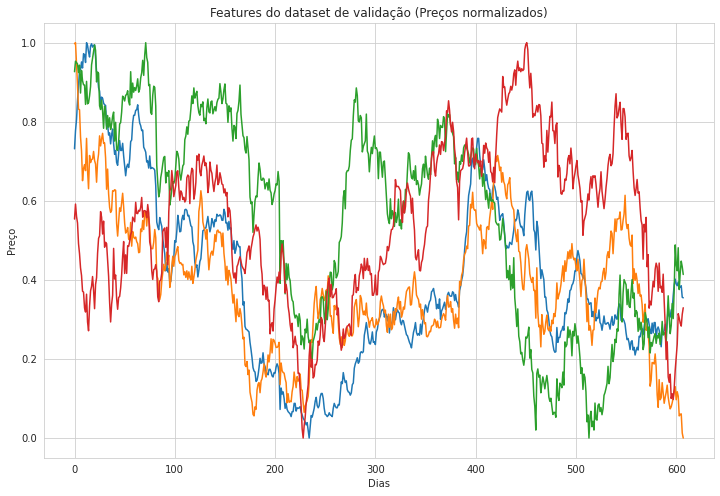

In [ ]:
# Mostra as features do dataset de validação
plt.rcParams['figure.figsize'] = (12,8)
plt.plot(cv_scaled)
plt.xlabel("Dias")
plt.ylabel("Preço")
plt.title("Features do dataset de validação (Preços normalizados)")
plt.show()

#### Construção e treinamento da rede LSTM

In [ ]:
# Criação da rede LSTM
model = Sequential()
# Adiciona a primeira camada LSTM e Dropout
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1], x_train_scaled.shape[2])))
model.add(Dropout(dropout_prob))
# Adiciona a segunda camada LSTM e Dropout
lstm_units_80_pct = round(lstm_units * 0.8) # definir 80% de neurônios para segunda camada
model.add(LSTM(units=lstm_units_80_pct))
model.add(Dropout(dropout_prob))
# Adiciona a camada de saída
model.add(Dense(1))
# Compila a rede
model.compile(loss='mean_squared_error', optimizer=optimizer)
# Treina a rede
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 9, 140)            81200     
_________________________________________________________________
dropout (Dropout)            (None, 9, 140)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 112)               113344    
_________________________________________________________________
dropout_1 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 113       
Total params: 194,657
Trainable params: 194,657
Non-trainable params: 0
_________________________________________________________________


#### Previsão inicial com dados de validação (antes da otimização dos hiperparâmetros)

In [ ]:
# Efetua a previsão sobre os dados de validação 
est_scaled = model.predict(x_cv_scaled)
# Retorno à escala normal para cálculo das métricas
est = scaler_y_cv.inverse_transform(est_scaled.reshape(-1,1)).reshape(-1)

# Calcula RMSE 
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calcula MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

RMSE = 0.151
MAPE = 17.001%


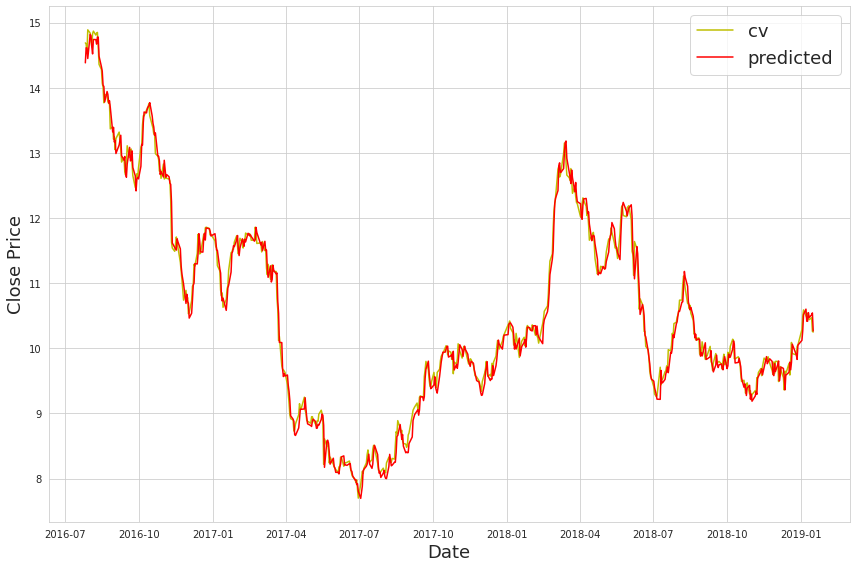

In [ ]:
# Estrutura os dados de validação original e previsto para apresentação
y_cv_df = cv[N:].ccm_usd
est_df = pd.DataFrame({'est': est.reshape(-1), 'y_cv': y_cv.reshape(-1)}, index=y_cv_df.index)
# Gráfico dos resultados original e previsto dos dados de validação 
plt.figure(figsize=(12,8))
plt.plot(y_cv_df, 'y-', label='cv')
plt.plot(est_df[['est']], 'r-', label='predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

In [ ]:
#Salva o resultado da previsão antes da otimização de hiperparâmetros
est_df.to_csv("./multivariado_lstm_previsao_inicial_antes_da_otimizacao.csv")
est_df

,est,y_cv
date,,
2016-07-26,14.383257,14.69
2016-07-27,14.614937,14.67
2016-07-28,14.609307,14.53
2016-07-29,14.449706,14.89
2016-08-01,14.819559,14.84
...,...,...
2019-01-10,10.547132,10.46
2019-01-11,10.473106,10.44
2019-01-14,10.513675,10.47


#### Otimização do número de dias da janela de features (window-size)

In [ ]:
param_label = 'N'
param_range = range(6, 24, 3)

error_rate = {param_label : [], 'rmse': [], 'mape': []}
tic = time.time()

for param in tqdm_notebook(param_range):
    
    # Split train into x and y
    x_train_scaled = get_x(train_scaled, param, param)
    y_train_scaled = train_scaled[param:, 0:1]
    
    # Split cv into x and y
    x_cv_scaled = get_x(cv_scaled, param, param)
    y_cv = cv.iloc[param:, 0:1].values #só coluna da série alvo
    y_cv_scaled = scaler_y_cv.fit_transform(y_cv)

    # A função abaixo serve para treinar, gerar previsão e avaliar os resultados através da função de perda
    rmse, mape, est_N = train_pred_eval_model(x_train_scaled, y_train_scaled,
                                          x_cv_scaled, y_cv, scaler_y_cv,
                                          lstm_units=lstm_units,
                                          dropout_prob=dropout_prob,
                                          optimizer=optimizer,
                                          epochs=epochs,
                                          batch_size=batch_size)
    
    # Coleta os resultados
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
toc = time.time()
print('Tempo em minutos: {}'.format((toc - tic) / 60.0))
error_rate

  0%|          | 0/6 [00:00<?, ?it/s]

Tempo em minutos: 46.567114380995434


,N,rmse,mape
0,6,0.157123,16.786697
1,9,0.153339,17.012401
2,12,0.149043,16.832469
3,15,0.165227,16.892638
4,18,0.150130,16.346561
5,21,0.205528,15.669414


In [ ]:
# Salva o data frame com a taxa de erro da rede
error_rate.to_csv("./multivariado_lstm_otimizacao_window_size.csv")

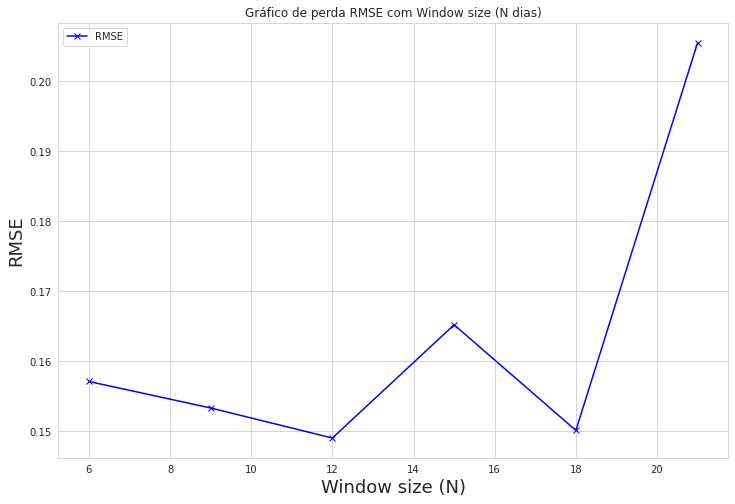

In [ ]:
# Gáfico RMSE com window size
plt.figure(figsize=(12, 8))
plt.plot(error_rate[param_label], error_rate['rmse'], 'bx-', label='RMSE')
#plt.plot(error_rate[param_label], error_rate['mape'], 'rx-', label='MAPE')
plt.xlabel('Window size (N)', fontsize=18)
plt.ylabel('RMSE', fontsize=18)
plt.title('Gráfico de perda RMSE com Window size (N dias)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Seleciona melhores parâmetros
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 0.149
min MAPE = 15.669%
optimum N = 12


#### Otimização do número de épocas (epochs) e lote (batch_size)

In [ ]:
param_label = 'epochs'
epochs_list = [100, 120, 140, 160, 180, 200, 250]

param_label1 = 'batch_size'
batch_size_list = [16, 32]

# Split train into x and y
x_train_scaled = get_x(train_scaled, N_opt, N_opt)
y_train_scaled = train_scaled[N_opt:, 0:1]
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

# Split cv into x and y
x_cv_scaled = get_x(cv_scaled, N_opt, N_opt)
y_cv = cv.iloc[N_opt:, 0:1].values #só coluna da série alvo
y_cv_scaled = scaler_y_cv.fit_transform(y_cv)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))

error_rate = {param_label : [], param_label1: [], 'rmse': [], 'mape': []}
tic = time.time()

for epoch in tqdm_notebook(epochs_list):
   
    for batch_len in tqdm_notebook(batch_size_list):
        # train, predict and eval with LSTM model
        rmse, mape, est_epoc = train_pred_eval_model(x_train_scaled, y_train_scaled,
                                              x_cv_scaled, y_cv, scaler_y_cv,
                                              lstm_units=lstm_units,
                                              dropout_prob=dropout_prob,
                                              optimizer=optimizer,
                                              epochs=epoch,
                                              batch_size=batch_len)

        # Collect results
        error_rate[param_label].append(epoch)
        error_rate[param_label1].append(batch_len)                           
        error_rate['rmse'].append(rmse)
        error_rate['mape'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print('Tempo em minutos: {}'.format((toc - tic) / 60.0))
# Save error_rate dataframe to avoid repetative computation
error_rate.to_csv("./multivariado_lstm_otimizacao_epochs_batch.csv")
error_rate

x_train_scaled.shape = (1816, 12, 4)
y_train_scaled.shape = (1816, 1)
x_cv_scaled.shape = (596, 12, 4)
y_cv.shape = (596, 1)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Tempo em minutos: 83.95092206398645


,epochs,batch_size,rmse,mape
0,100,16,0.156075,16.559160
1,100,32,0.162348,16.767326
2,120,16,0.152336,16.830738
3,120,32,0.169144,16.621674
4,140,16,0.160283,16.738209
5,140,32,0.152319,16.730823
6,160,16,0.149430,16.798678
7,160,32,0.151807,16.861940
8,180,16,0.162361,16.419947
9,180,32,0.150538,16.612964


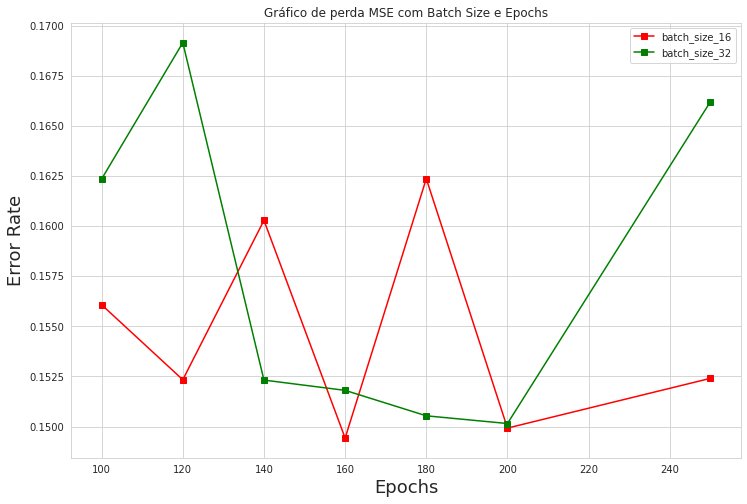

In [ ]:
## Gárfico RMSE com Épocha e Batch_size
plt.figure(figsize=(12, 8))
color_list = ['r', 'g', 'k', 'y', 'm']

for i in range(len(batch_size_list)):
    plt.plot(epochs_list, error_rate.loc[error_rate[param_label1] == batch_size_list[i], 'rmse'], 
             color_list[i % len(color_list)], marker='s', label='batch_size_' + str(batch_size_list[i]))
    
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Error Rate', fontsize=18)
plt.title('Gráfico de perda MSE com Batch Size e Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Seleciona melhores parametros para batch_size e épocha
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param_label1].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param_label1 + " = " + str(batch_size_opt))

min RMSE = 0.149
min MAPE = 16.420%
optimum epochs = 160
optimum batch_size = 16


#### Otimização do número de neurônios (units) e taxa de eliminação (dropout)

In [ ]:
param_label = 'lstm_units'
lstm_unit_list = [100, 120, 140, 160, 180, 200]

param_label1 = 'dropout_prob'
dropout_list = [0.2]

# Split train into x and y
x_train_scaled = get_x(train_scaled, N_opt, N_opt)
y_train_scaled = train_scaled[N_opt:, 0:1]
print("x_train_scaled.shape = " + str(x_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

# Split cv into x and y
x_cv_scaled = get_x(cv_scaled, N_opt, N_opt)
y_cv = cv.iloc[N_opt:, 0:1].values #só coluna da série alvo
y_cv_scaled = scaler_y_cv.fit_transform(y_cv)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))

error_rate = {param_label : [], param_label1: [], 'rmse': [], 'mape': []}
tic = time.time()

for no_lstm_unit in tqdm_notebook(lstm_unit_list):
    
    for dropout in tqdm_notebook(dropout_list):
        # train, predict and eval with LSTM model
        print(f'Excuting For {no_lstm_unit} units and with dropout probability {dropout}')
        rmse, mape, est_unit = train_pred_eval_model(x_train_scaled, y_train_scaled,
                                              x_cv_scaled, y_cv, scaler_y_cv,
                                              lstm_units=no_lstm_unit,
                                              dropout_prob=dropout,
                                              optimizer=optimizer,
                                              epochs=epochs_opt,
                                              batch_size=batch_size_opt)

        # Collect results
        error_rate[param_label].append(no_lstm_unit)
        error_rate[param_label1].append(dropout)                              
        error_rate['rmse'].append(rmse)
        error_rate['mape'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print('Tempo em minutos: {}'.format((toc - tic) / 60.0))
# Save error_rate dataframe to avoid repetative computation
error_rate.to_csv("./multivariado_lstm_otimizacao_unit_dropout.csv")
error_rate

x_train_scaled.shape = (1816, 12, 4)
y_train_scaled.shape = (1816, 1)
x_cv_scaled.shape = (596, 12, 4)
y_cv.shape = (596, 1)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 100 units and with dropout probability 0.2


  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 120 units and with dropout probability 0.2


  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 140 units and with dropout probability 0.2


  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 160 units and with dropout probability 0.2


  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 180 units and with dropout probability 0.2


  0%|          | 0/1 [00:00<?, ?it/s]

Excuting For 200 units and with dropout probability 0.2
Tempo em minutos: 52.10088638861974


,lstm_units,dropout_prob,rmse,mape
0,100,0.2,0.198746,17.151284
1,120,0.2,0.161243,17.052383
2,140,0.2,0.160764,16.539570
3,160,0.2,0.168164,16.485851
4,180,0.2,0.147951,16.732915
5,200,0.2,0.172056,16.510873


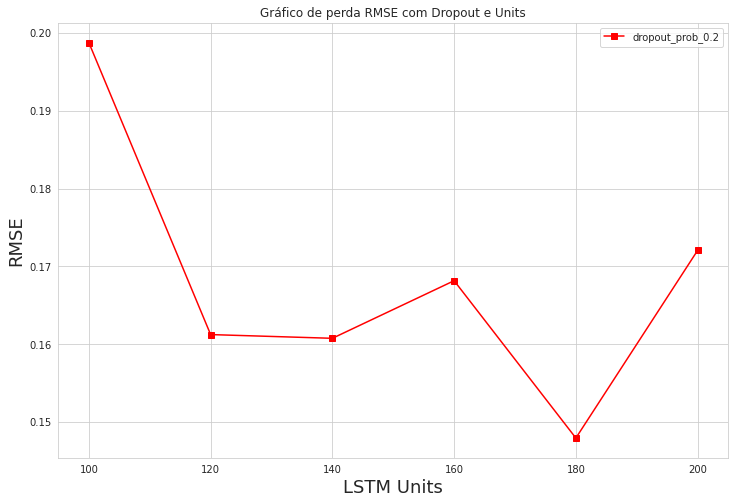

In [ ]:
## Gráfico de RMSE com units e dropout
plt.figure(figsize=(12, 8))
color_list = ['r', 'g', 'k', 'y', 'm']

for i in range(len(dropout_list)):
    plt.plot(lstm_unit_list, error_rate.loc[error_rate[param_label1] == dropout_list[i], 'rmse'], 
             color_list[i % len(color_list)], marker='s', label='dropout_prob_' + str(dropout_list[i]))
    
plt.xlabel('LSTM Units', fontsize=18)
plt.ylabel('RMSE', fontsize=18)
plt.title('Gráfico de perda RMSE com Dropout e Units')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Get optimum value for lstm units and dropout probs
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param_label1].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param_label1 + " = " + str(dropout_prob_opt))

min RMSE = 0.148
min MAPE = 16.486%
optimum lstm_units = 180
optimum dropout_prob = 0.2


#### Parametros otimizados

In [ ]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'epochs', 'batch_size', 'rmse', 'mape'],
     'original': [N, lstm_units, dropout_prob, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape'].min()]}
tuned_params = pd.DataFrame(d)
#Salva os hiperparâmetros após a otimização
tuned_params.to_csv("./multivariado_lstm_hiperparametros_otimizados.csv")
tuned_params

,param,original,after_tuning
0,N,9.00000,12.000000
1,lstm_units,140.00000,180.000000
2,dropout_prob,0.20000,0.200000
3,epochs,160.00000,160.000000
4,batch_size,16.00000,16.000000
5,rmse,0.15104,0.147951
6,mape,17.00079,16.485851


## Modelo final

In [ ]:
# Normaliza o dataset train_cv para usar no modelo final
scaler_final = MinMaxScaler()
train_cv_scaled_final = scaler_final.fit_transform(train_cv.iloc[:, 0:4].values) #só coluna da série em si

# Divide o datase train_cv em x e y
x_train_cv_scaled = get_x(train_cv_scaled_final, N_opt, N_opt)
y_train_cv_scaled = train_cv_scaled_final[N_opt:, 0:1]
print("x_train_cv_scaled.shape = " + str(x_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))

# Normaliza o dataset de teste para usar no modelo final
test_scaled = scaler_features.fit_transform(test.iloc[:, 0:4].values) #só coluna da série em si

# Divide o datase test em x e y
scaler_test = MinMaxScaler()
x_test_scaled = get_x(test_scaled, N_opt, N_opt)
y_test = test.iloc[N_opt:, 0:1].values #y_test contem os dados originais (não normalizados)
y_test_scaled = scaler_test.fit_transform(y_test)


print("x_test_scaled.shape = " + str(x_test_scaled.shape))
print("y_test.shape = " + str(y_test.shape))

x_train_cv_scaled.shape = (2424, 12, 4)
y_train_cv_scaled.shape = (2424, 1)
x_test_scaled.shape = (596, 12, 4)
y_test.shape = (596, 1)


In [ ]:
# Trainamento, previsão e avaliação do modelo
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled,
                                        y_train_cv_scaled,
                                        x_test_scaled,
                                        y_test,
                                        scaler_test,
                                        lstm_units=lstm_units_opt,
                                        dropout_prob=dropout_prob_opt,
                                        optimizer=optimizer,
                                        epochs=epochs_opt,
                                        batch_size=batch_size_opt)


# RMSE
print("RMSE on test set = %0.3f" % rmse)
# MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 0.169
MAPE on test set = 28.335%


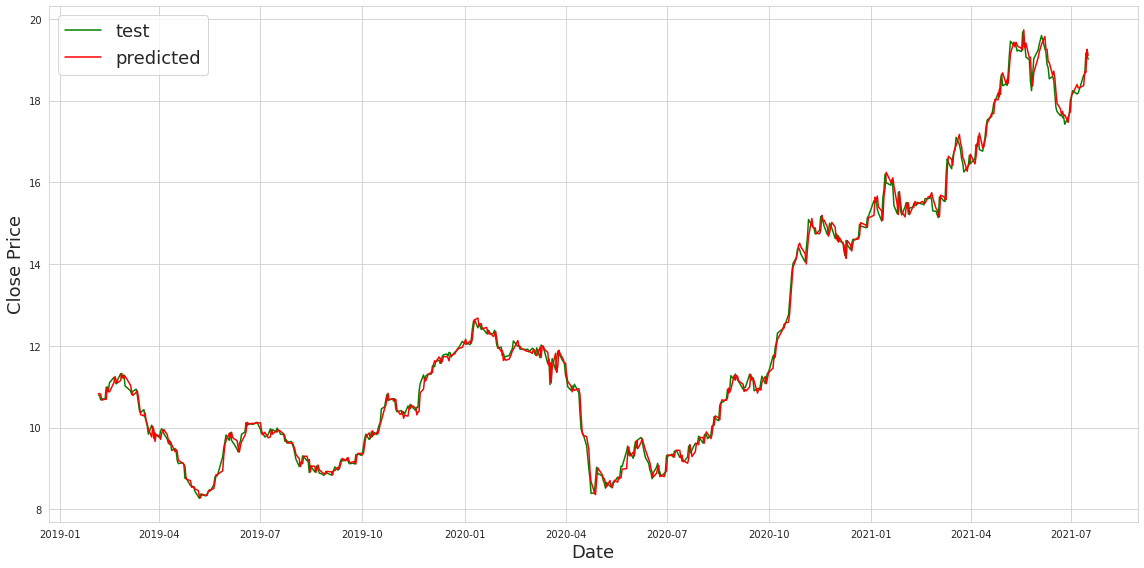

In [ ]:
y_test = test.iloc[N_opt:, 0:1].values #coluna da série alvo original
y_test_df = test[N_opt:].ccm_usd
est_df = pd.DataFrame({'est': est.reshape(-1), 'y_test': y_test.reshape(-1)}, index= y_test_df.index)

# Gráfico dos valores original e previsto no conjunto de teste
plt.figure(figsize=(16, 8))
plt.plot(y_test_df, 'g-', label='test')
plt.plot(est_df[['est']], 'r-', label='predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

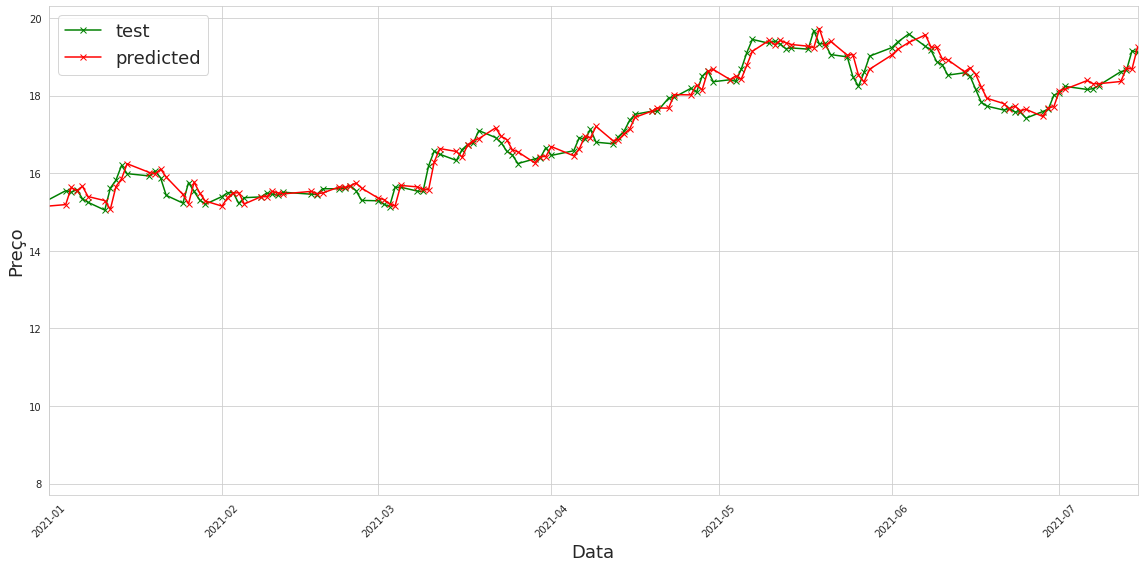

In [ ]:
# Zoom no dataset de teste original e previsto
plt.figure(figsize=(16, 8))
plt.plot(y_test_df, 'gx-', label='test')
plt.plot(est_df[['est']], 'rx-', label='predicted')
plt.xlim([date(2021, 1, 1), date(2021, 7, 15)])
plt.xticks(rotation=45)
plt.xlabel('Data', fontsize=18)
plt.ylabel('Preço', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_lstm = est_df
#Salva o resultado da previsão após a otimização de hiperparâmetros
test_lstm.to_csv("./multivariado_lstm_previsao_final_apos_otimizacao.csv")
test_lstm

,est,y_test
date,,
2019-02-05,10.826828,10.80
2019-02-06,10.834811,10.79
2019-02-07,10.816545,10.68
2019-02-08,10.673788,10.71
2019-02-11,10.696605,10.69
...,...,...
2021-07-12,18.365385,18.62
2021-07-13,18.709843,18.65
2021-07-14,18.686636,19.16
